### Plotting Test
Alex is using this Jupyter notebook to test the plotting + print statements from query.py.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lsst.rsp import get_tap_service
import query as q

##### Testing object classifcation
There are two ways this classification function works:
1. Providing orbit parameters, returning a corresponding object type
2. Providing an object type, reutrning corresponding orbit parameters

In [2]:
# 1
input_params = {
        "q_cutoff_min": None, 
        "q_cutoff": 1.3, 
        "a_cutoff_min": None, 
        "a_cutoff": 4.0, 
        "e_cutoff_min": None, 
        "e_cutoff": 1.0}
object_type = q.type_classification(input_params = input_params)
print(object_type)

#2
params = q.type_classification(object_type = "NEO")
print(params)

NEO
{'q_cutoff': 1.3, 'a_cutoff': 4.0, 'e_cutoff': 1.0}


Now that know our classification works, let's try making a full query. 

In [3]:
# testing with NEOs
query, object_type = q.make_query_general(object_type = "NEO", join = 'Diasource')
print(query)
print(object_type)

query, object_type = q.make_query_general(q_cutoff=1.3, a_cutoff=4.0, e_cutoff = 1.0, join = 'Diasource')
print(query)
print(object_type) 

SELECT mpc.incl, mpc.q, mpc.e, mpc.ssObjectID, dias.magTrueVband FROM dp03_catalogs_10yr.MPCORB as mpc
    INNER JOIN dp03_catalogs_10yr.DiaSource AS dias ON mpc.ssObjectId = dias.ssObjectId
    WHERE mpc.q < 1.3 AND mpc.e < 1.0 AND mpc.q/(1-mpc.e) < 4.0;
NEO
SELECT mpc.incl, mpc.q, mpc.e, mpc.ssObjectID, dias.magTrueVband FROM dp03_catalogs_10yr.MPCORB as mpc
    INNER JOIN dp03_catalogs_10yr.DiaSource AS dias ON mpc.ssObjectId = dias.ssObjectId
    WHERE mpc.q < 1.3 AND mpc.e < 1.0 AND mpc.q/(1-mpc.e) < 4.0;
NEO


In [4]:
# running the query
NEO_objects_table = q.run_query(query)

Job phase is COMPLETED
     incl              q          ...     ssObjectID     magTrueVband
     deg               AU         ...                                
-------------- ------------------ ... ------------------ ------------
9.299357471305 1.0442646753695681 ... 103227822147177228     22.00147
9.299357471305 1.0442646753695681 ... 103227822147177228    22.000353
9.299357471305 1.0442646753695681 ... 103227822147177228    21.968763
9.299357471305 1.0442646753695681 ... 103227822147177228    22.549915
9.299357471305 1.0442646753695681 ... 103227822147177228    21.820671


In [5]:
a = q.calc_semimajor_axis(NEO_objects_table['q'], NEO_objects_table['e'])
NEO_objects_table['a'] = a
print(NEO_objects_table[0:5]) # print first few rows 

     incl              q          ... magTrueVband         a         
     deg               AU         ...                                
-------------- ------------------ ... ------------ ------------------
9.299357471305 1.0442646753695681 ...     22.00147 2.1045410617919846
9.299357471305 1.0442646753695681 ...    22.000353 2.1045410617919846
9.299357471305 1.0442646753695681 ...    21.968763 2.1045410617919846
9.299357471305 1.0442646753695681 ...    22.549915 2.1045410617919846
9.299357471305 1.0442646753695681 ...    21.820671 2.1045410617919846


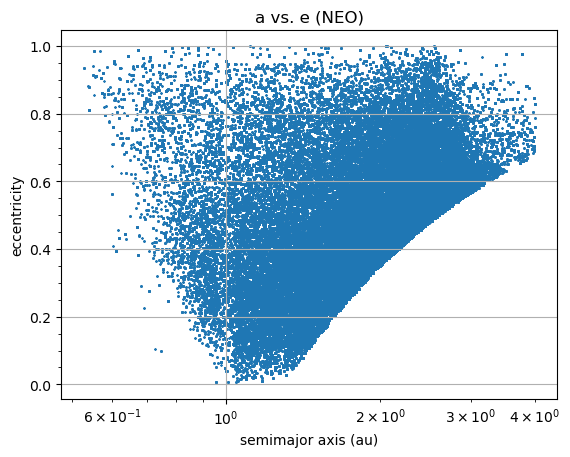

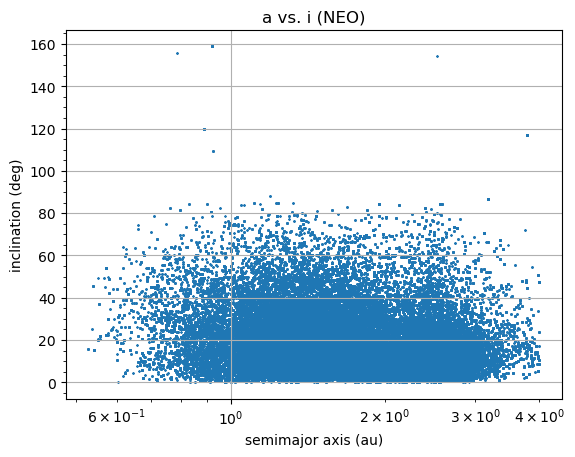

In [7]:
q.plot_data(NEO_objects_table, object_type)

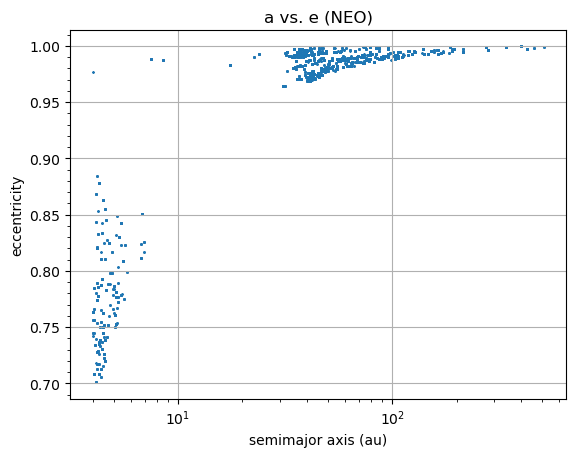

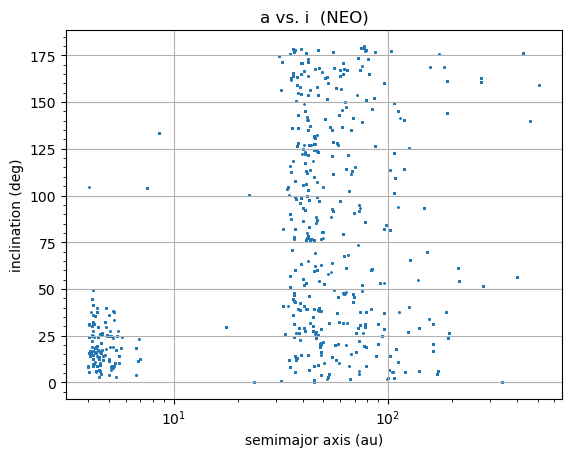

In [16]:
# # Orbital parameter plot (a vs e)
# fig, ax = plt.subplots()
# # plt.xlim([0., 4.])
# # plt.ylim([0., 1.])
# ax.scatter(NEO_objects_table["a"], NEO_objects_table["e"], s=0.1) # a vs. i
# ax.set_xscale('log')
# ax.set_xlabel('semimajor axis (au)')
# ax.set_ylabel('eccentricity')
# ax.set_title("a vs. e (NEO)")
# ax.minorticks_on()
# ax.grid()
# plt.show()

# object_type = "NEO"
# # Orbital parameter plot (a vs i)
# fig, ax = plt.subplots()
# # plt.xlim([0., 4.])
# # plt.ylim([0., 1.])
# ax.scatter(NEO_objects_table["a"], NEO_objects_table["incl"], s=0.1) # a vs. i
# ax.set_xscale('log')
# ax.set_xlabel('semimajor axis (au)')
# ax.set_ylabel('inclination (deg)')
# ax.set_title("a vs. i  (" + object_type + ")")
# ax.minorticks_on()
# ax.grid()
# plt.show()

In [6]:
q.type_counts(NEO_objects_table)

MBA Count: 0
NEO Count: 3049
TNO Count: 328
Centaur Count: 273
LPC Count: 326


### Joining Original Query with DiaSource

In [2]:
# joins together MPC 10 year dataset with the DiaSource dataset by ssObjectId
query = q.make_query(q_cutoff=1.3, a_cutoff_min=4.0, e_cutoff = 1.0, join = 'Diasource')
print(query)


SELECT mpc.incl, mpc.q, mpc.e, mpc.ssObjectID, dias.magTrueVband FROM dp03_catalogs_10yr.MPCORB as mpc
    INNER JOIN dp03_catalogs_10yr.DiaSource AS dias ON mpc.ssObjectId = dias.ssObjectId
    WHERE mpc.q < 1.3 AND mpc.e < 1.0 AND mpc.q/(1-mpc.e) > 4.0;


In [3]:
# run query
DiaSource_joined_table = q.run_query(query)

Job phase is COMPLETED
       incl                q          ...     ssObjectID    magTrueVband
       deg                 AU         ...                               
------------------ ------------------ ... ----------------- ------------
20.142954773991445 0.9796930871750984 ... 49552943011975823    23.838762
20.142954773991445 0.9796930871750984 ... 49552943011975823    23.837643
20.142954773991445 0.9796930871750984 ... 49552943011975823    23.828745
20.142954773991445 0.9796930871750984 ... 49552943011975823     24.23662
20.142954773991445 0.9796930871750984 ... 49552943011975823    23.837542


In [5]:
# add 'a' column
a = q.calc_semimajor_axis(DiaSource_joined_table['q'], DiaSource_joined_table['e'])
DiaSource_joined_table['a'] = a

#### How many observations for each object? In what filters?

In [6]:
# turning the Astropy table into a pandas dataframe (mainly so I don't have to deal with masked columns)
df = DiaSource_joined_table.to_pandas()

# need to count observations for each unique object in SSO_id
print(df['ssObjectID'].value_counts())

ssObjectID
 1270290272812673240    318
-34358999358465183      234
 2510535089237011001    214
-7893956473845476949    210
 3946076054574751788    204
                       ... 
 7376735457890935512      9
 7453615499783257273      8
-8199397495883662837      8
-7634281816284682685      7
 7680793371230911070      7
Name: count, Length: 492, dtype: int64


In [5]:
# what filters? 

#### What is the average magnitude range? Does any object have an unusually large range?

In [6]:
service = get_tap_service("ssotap")
assert service is not None
results = service.search("SELECT column_name, datatype, description, "
                         "unit from TAP_SCHEMA.columns "
                         "WHERE table_name = 'dp03_catalogs_10yr.DiaSource'")
results.to_table().to_pandas()

,column_name,datatype,description,unit
0,band,char,Name of the band used to take the exposure whe...,
1,ccdVisitId,int,Id of the ccdVisit where this diaSource was me...,
2,dec,double,Dec-coordinate of the center of this diaSource.,deg
3,decErr,float,Uncertainty of dec.,deg
4,decTrue,double,True (noiseless) declination of the simulated ...,
5,diaObjectId,long,Id of the diaObject this source was associated...,
6,diaSourceId,long,Unique id.,
7,mag,float,Magnitude. This is a placeholder and should be...,
8,magErr,float,Magnitude error. This is a placeholder and sho...,
9,magTrueVband,float,True (noiseless) V-band magnitude of the simul...,


In [7]:
results['description'][9]

np.str_('True (noiseless) V-band magnitude of the simulated diaSource')

In [7]:
df.columns

Index(['incl', 'q', 'e', 'ssObjectID', 'magTrueVband', 'a'], dtype='object')

In [8]:
# adding 'type' column
df['Class'] = df.apply(q.type_classification, axis=1)
print(df)


             incl         q         e         ssObjectID  magTrueVband  \
0       20.142955  0.979693  0.980004  49552943011975823     23.838762   
1       20.142955  0.979693  0.980004  49552943011975823     23.837643   
2       20.142955  0.979693  0.980004  49552943011975823     23.828745   
3       20.142955  0.979693  0.980004  49552943011975823     24.236620   
4       20.142955  0.979693  0.980004  49552943011975823     23.837542   
...           ...       ...       ...                ...           ...   
28940  154.315301  0.358184  0.990890 -19272383454960270     24.056637   
28941  154.315301  0.358184  0.990890 -19272383454960270     20.456377   
28942  154.315301  0.358184  0.990890 -19272383454960270     21.120903   
28943  154.315301  0.358184  0.990890 -19272383454960270     18.759665   
28944  154.315301  0.358184  0.990890 -19272383454960270     19.387869   

               a Class  
0      48.994672   NEO  
1      48.994672   NEO  
2      48.994672   NEO  
3      48.9

In [9]:
# need to group by unique ssObjectID values
# create new dataframe to hold average of each group 

print(df.columns)

mag_data = df.groupby(['ssObjectID']).agg(
    mag_mean = ('magTrueVband', 'mean'))

print(mag_data)

Index(['incl', 'q', 'e', 'ssObjectID', 'magTrueVband', 'a', 'Class'], dtype='object')
                       mag_mean
ssObjectID                     
-9148239178685334337  21.998495
-9107056889034294513  32.579948
-9095432462150332340  18.361084
-8998070713432935796  19.151974
-8962368697841326271  21.892792
...                         ...
 8906832681098804506  21.802177
 9010956620758146911  22.967888
 9022961864831958355  21.921072
 9034671437756444180  32.840210
 9117326962743268631  23.037796

[492 rows x 1 columns]


#### Now need to look at the average range
For each object, need to find the average range? So, min and max for each observation?
-> I think this means the average range by object type, so I'm going to group by object type, then find min and max V values from each object type

In [10]:
df.groupby('Class')['magTrueVband'].min()

Class
NEO    12.841971
Name: magTrueVband, dtype: float32

In [11]:
df.groupby('Class')['magTrueVband'].max()

Class
NEO    35.641945
Name: magTrueVband, dtype: float32

In [13]:
q.type_counts(DiaSource_joined_table)

MBA Count: 0
NEO Count: 28945
TNO Count: 11521
Centaur Count: 770
LPC Count: 11594
